# Importing Libraries And Loading The Dataset


In [ ]:
# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

# Plotting and Model Evaulation Libraries
import matplotlib.pyplot as plt
import IPython.display as ipd
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Utility Libraries
import numpy as np
import pandas as pd
import os

# Setting seed for reproducibility
keras.utils.set_random_seed(42)

# Librosa
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abdelrahmanessmat","key":"55740a29498c91a252924460aa8ccde9"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

100% 1.21G/1.21G [00:09<00:00, 165MB/s]
100% 1.21G/1.21G [00:09<00:00, 139MB/s]


In [ ]:
! unzip /content/gtzan-dataset-music-genre-classification.zip

Archive:  /content/gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues

# Data Loading and Exploration

In [ ]:
training_images_filepath = "/content/Data/images_original"
category_labels = os.listdir(training_images_filepath)

xdim = 180
ydim = 180

spectograms = image_dataset_from_directory(
    training_images_filepath,
    image_size = (xdim, ydim),
    batch_size = 111)

## Use num_batches - 2 batches for training, 1 batch for validation, 1 batch for testing
num_batches = tf.data.experimental.cardinality(spectograms).numpy()
train = spectograms.take(num_batches - 2).cache()
remaining = spectograms.skip(num_batches - 2)
validation = remaining.take(1).cache()
test = remaining.skip(1).cache()

Found 999 files belonging to 10 classes.


In [ ]:
import os
general_path = '/content/Data'
print(list(os.listdir(f'{general_path}/genres_original/')))

['disco', 'metal', 'classical', 'hiphop', 'jazz', 'country', 'blues', 'reggae', 'rock', 'pop']


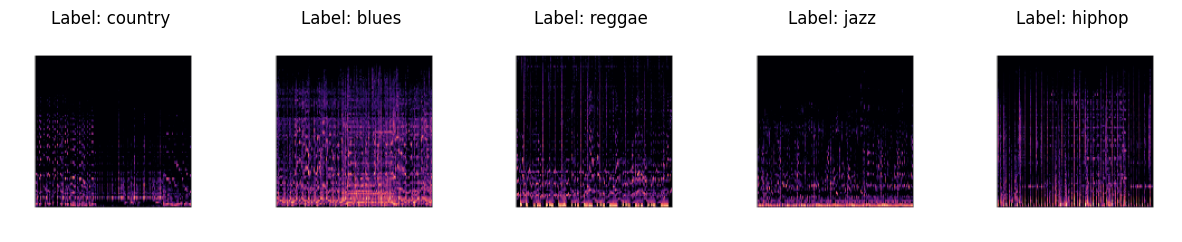

In [ ]:
for images, labels in validation:
    plt.figure(figsize=(15, 500))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {category_labels[labels[i].numpy()]}")
        plt.axis("off")
    plt.show()

In [ ]:
# Importing 1 file
y, sr = librosa.load(f'{general_path}/genres_original/reggae/reggae.00036.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verify length of the audio
print('Check Len of Audio:', 661794/22050)

y: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


In [ ]:
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

Audio File shape: (661794,)


### 2D Representation: Sound Waves


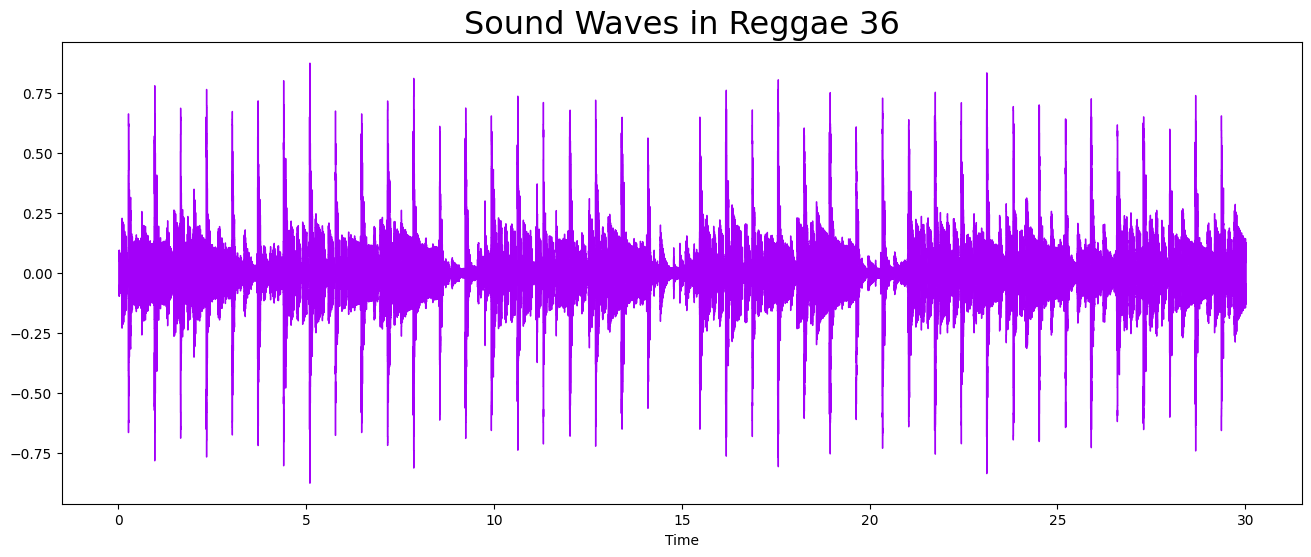

In [ ]:
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio_file, sr = sr, color = "#A300F9");
plt.title("Sound Waves in Reggae 36", fontsize = 23);

### The Spectrogram

In [ ]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(D))

Shape of D object: (1025, 1293)


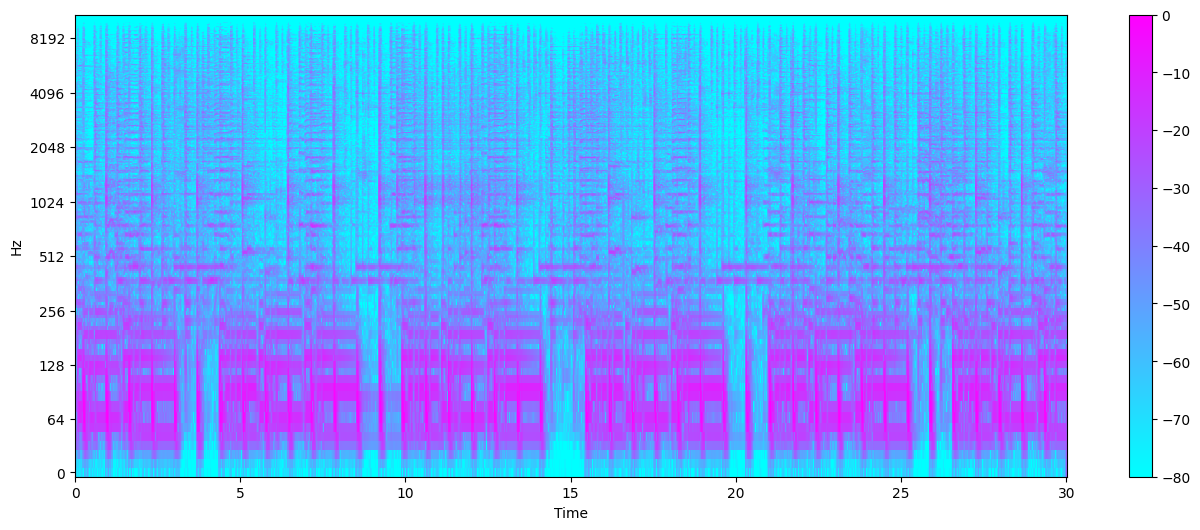

In [ ]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the Spectogram
plt.figure(figsize = (16, 6))
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log', cmap = 'cool')
plt.colorbar();

# EDA

EDA is going to be performed on the `features_30_sec.csv`. This file contains the mean and variance for each audio file fo the features analysed above.

So, the table has a final of 1000 rows (10 genrex x 100 audio files) and 60 features (dimensionalities).

In [ ]:
data = pd.read_csv(f'{general_path}/features_30_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


### Correlation Heatmap for feature means

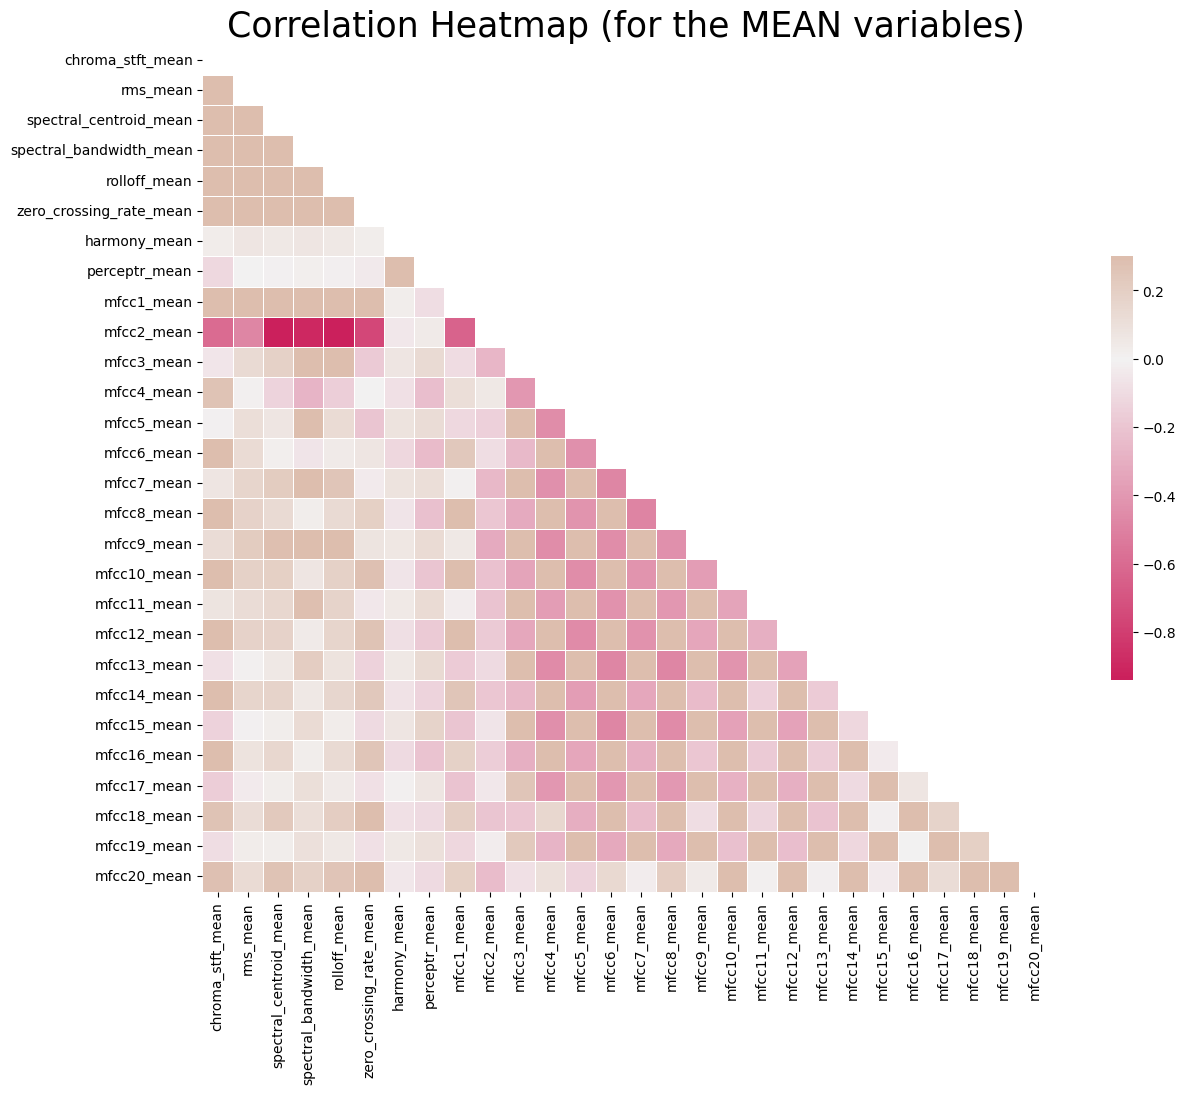

In [ ]:
# Computing the Correlation Matrix
spike_cols = [col for col in data.columns if 'mean' in col]
corr = data[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr Heatmap.jpg")

### Box Plot for Genres Distributions

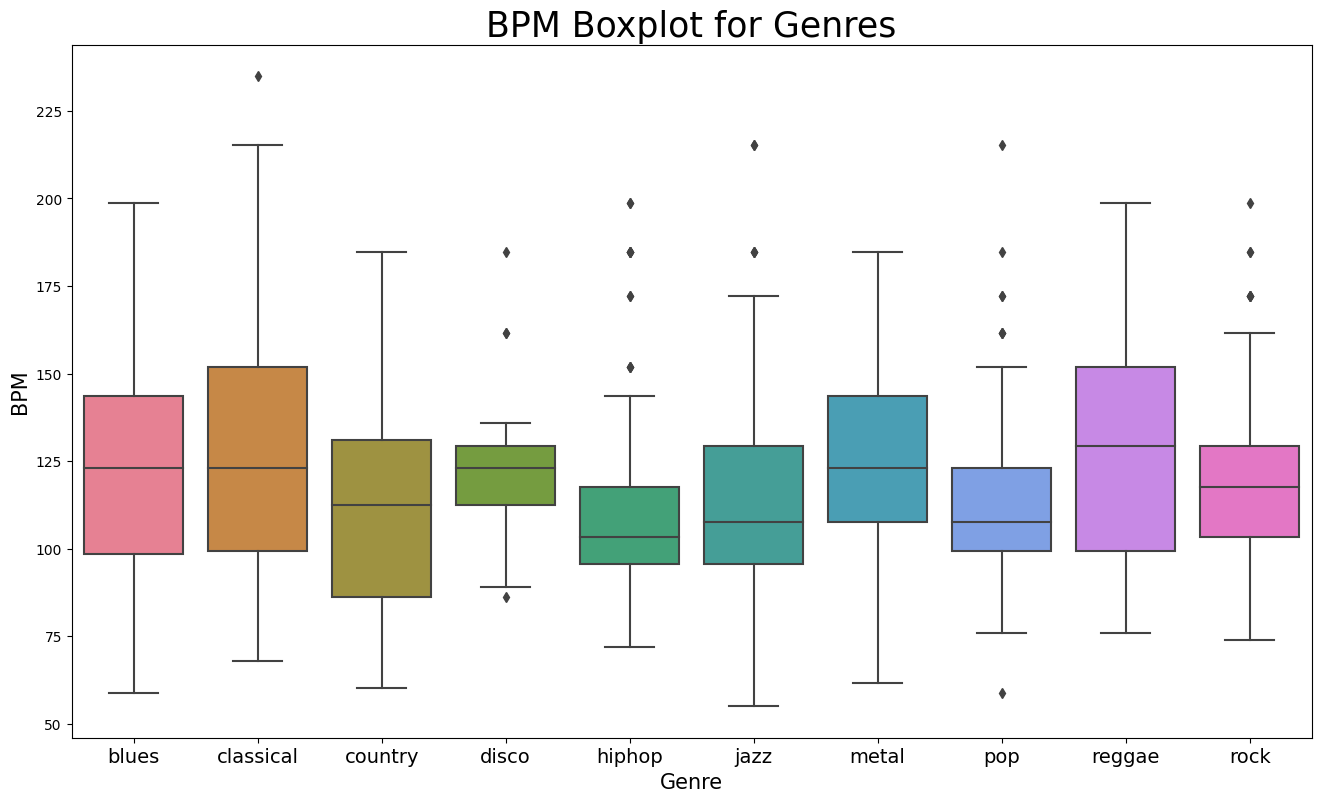

In [ ]:
x = data[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM Boxplot.jpg")

### Principal Component Analysis - to visualize possible groups of genres

In [ ]:
from sklearn import preprocessing

data = data.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# NORMALIZE
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


# PCA 2 COMPONENTS
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# Concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_

array([0.2439355 , 0.21781804])

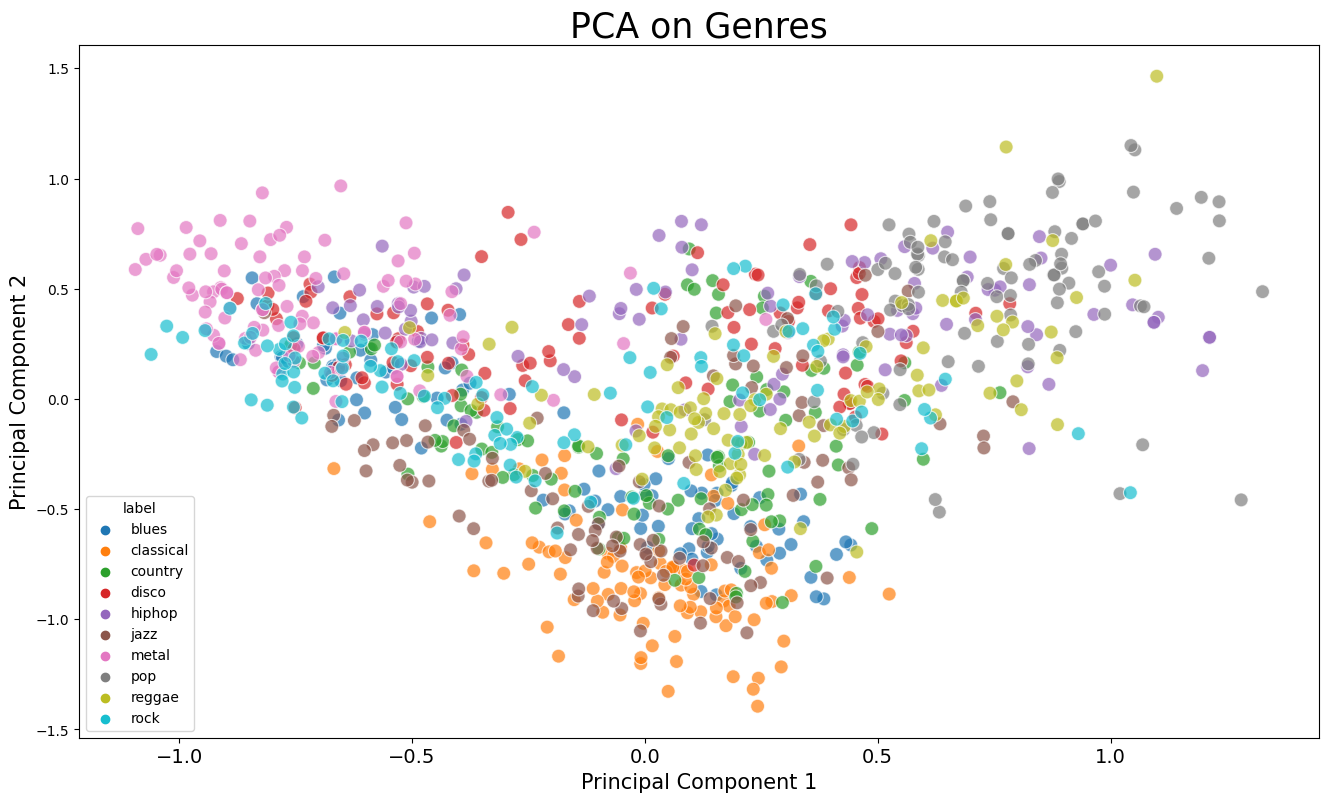

In [ ]:
plt.figure(figsize = (16, 9))

sns.scatterplot(x = "principal component 1",
                y = "principal component 2",
                data = finalDf,
                hue = "label",
                alpha = 0.7,
                s = 100);

plt.title('PCA on Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA Scattert.jpg")

# Model Fine-Tuning


In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (xdim, ydim, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

For the first step of our fine-tuning, we will freeze the base model and add in our own head to train.  What this means is that we will add in our own layers to the VGG16 model and ONLY train the weights of the new layers while keeping the weights of the original layers in VGG16 the same.  For now, we will just add a simple head with 256 nodes and a relu activation function.

Note that without a GPU, each epoch takes about 110 seconds to run.

In [ ]:
# Freeze the layers
conv_base.trainable = False

# Define the new head
inputs = keras.Input(shape=(xdim, ydim, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(inputs)
x = layers.Flatten()(x)
x = layers.Dense(256, activation = "relu")(x)
outputs = layers.Dense(len(category_labels), activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    train,
    epochs = 100,
    validation_data = validation,
    verbose = 1)

Epoch 1/100
7/7 [==============================] - 20s 410ms/step - loss: 122.8799 - accuracy: 0.1338 - val_loss: 70.3940 - val_accuracy: 0.2613
Epoch 2/100
7/7 [==============================] - 2s 362ms/step - loss: 37.3400 - accuracy: 0.2947 - val_loss: 9.0265 - val_accuracy: 0.4685
Epoch 3/100
7/7 [==============================] - 2s 359ms/step - loss: 8.6330 - accuracy: 0.4736 - val_loss: 4.7564 - val_accuracy: 0.6126
Epoch 4/100
7/7 [==============================] - 2s 364ms/step - loss: 8.5148 - accuracy: 0.4968 - val_loss: 3.1319 - val_accuracy: 0.6306
Epoch 5/100
7/7 [==============================] - 3s 367ms/step - loss: 3.7188 - accuracy: 0.5894 - val_loss: 12.2188 - val_accuracy: 0.4595
Epoch 6/100
7/7 [==============================] - 3s 422ms/step - loss: 9.2628 - accuracy: 0.4852 - val_loss: 3.8442 - val_accuracy: 0.6036
Epoch 7/100
7/7 [==============================] - 3s 372ms/step - loss: 2.7961 - accuracy: 0.6885 - val_loss: 3.4273 - val_accuracy: 0.6847
Epoch 8

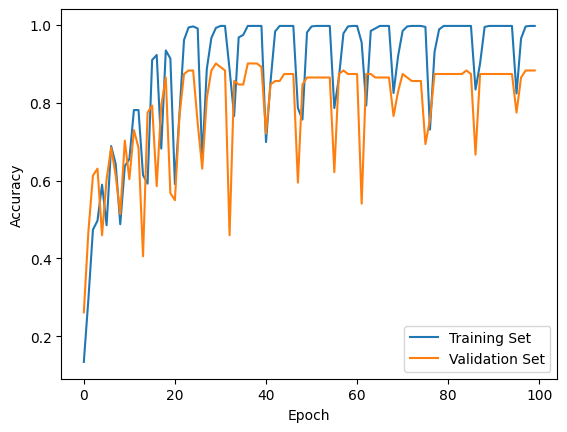

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training Set", "Validation Set"]);

Now that the head of our model is moderately trained, we further fine-tune the model by unfreezing the last four layers of the VGG16 model and tuning them plus the head layers.

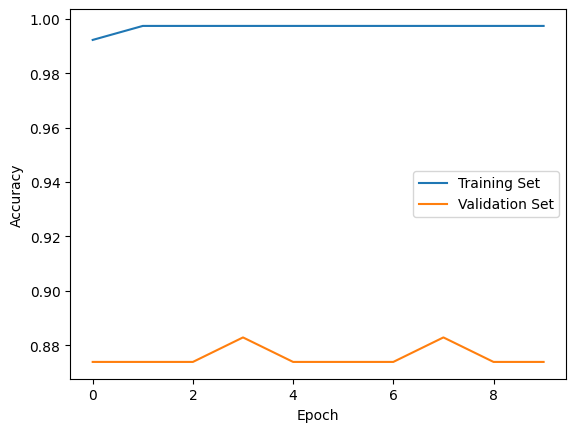

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

history = model.fit(
    train,
    epochs = 10,
    validation_data = validation,
    verbose = 0)

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training Set", "Validation Set"]);

Fine-tuning in this step does not seem to improve the accuracy of the model further, but it is still an important step since it very well could have.

## Model Evaluation

Now that we have our model, we can test its performance on the test set.

In [ ]:
predictions_prob = model.predict(test)
predictions = np.argmax(predictions_prob, axis = 1)

ground_truth = [label for _, label in test.unbatch()]
ground_truth = tf.stack(ground_truth, axis = 0).numpy()

accuracy = accuracy_score(ground_truth, predictions)
print("Accuracy of the model:", accuracy*100)

1/1 [==============================] - 3s 3s/step
Accuracy of the model: 0.918918918918919


We get an accuracy of just about 90%, which is very strong.  We can further analyze the performance by evaluating the confusion matrix.


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        11
           2       0.50      0.71      0.59         7
           3       0.86      1.00      0.92        12
           4       1.00      1.00      1.00         5
           5       0.92      1.00      0.96        12
           6       1.00      1.00      1.00        10
           7       1.00      0.94      0.97        18
           8       0.92      0.92      0.92        13
           9       1.00      0.62      0.76        13

    accuracy                           0.92       111
   macro avg       0.92      0.92      0.91       111
weighted avg       0.94      0.92      0.92       111



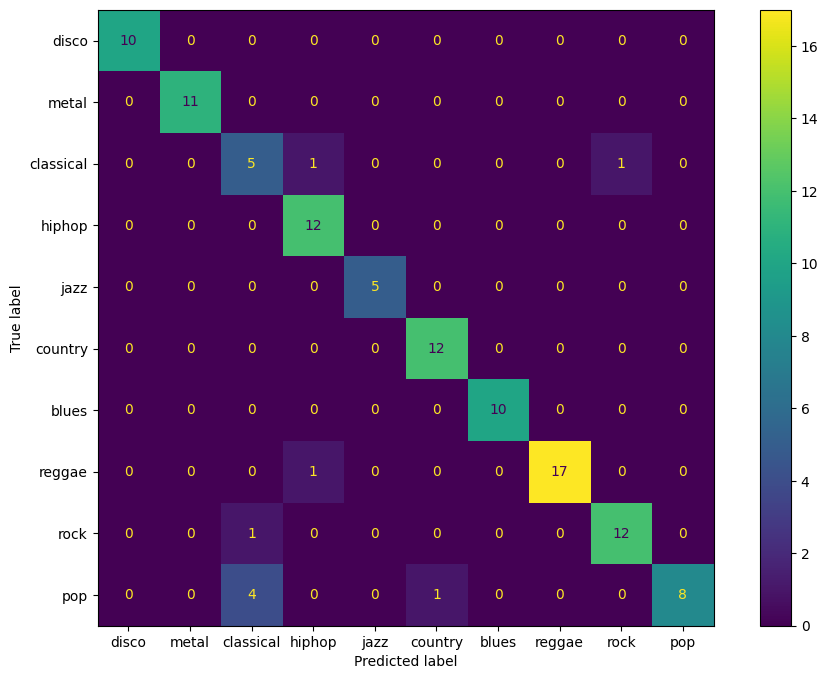

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
conf_matrix = confusion_matrix(ground_truth, predictions)
ConfusionMatrixDisplay(conf_matrix, display_labels = category_labels).plot(ax = ax)

report = classification_report(ground_truth, predictions)
print('\nClassification Report:\n', report)